<a href="https://colab.research.google.com/github/OkitwiOpio/Recess_Internship/blob/main/Workshop_2/Module_3_Detecting%20CNVs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![banner](https://github.com/anopheles-genomic-surveillance/anopheles-genomic-surveillance.github.io/blob/master/docs/banner.jpg?raw=1)

***[Workshop 2](about) - Training course in data analysis for genomic surveillance of African malaria vectors***

---

# Module 3 - Detecting CNVs from genome sequence data

**Theme: Data**

In this module we will learn about how we detect copy number variants (CNVs) from whole-genome sequencing data, and how to access and visualise the individual-level CNV data using the `malariagen_data` package in Python.

## Learning objectives

At the end of this module you will be able to:

* Explain what copy number variation is, and what is meant by CNV alleles
* Explain how we detect CNVs in whole-genome sequence data from MalariaGEN
* Access and visualise MalariaGEN CNV data

## Lecture

### English

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/-Pq8e-OZeNA" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Français

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/Xh6A9vBtJuE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Please note that the code in the cells below might differ from that shown in the video. This can happen because Python packages and their dependencies change due to updates, necessitating tweaks to the code.

## Introduction: what are CNVs?

Copy number variants (CNVs) are a type of mutation that changes the *number of copies* of a genetic region on the chromosome. That region might be deleted (reduction in copy number, called a *deletion*), or might be copied (increase in copy number, called a *duplication* or *amplification*). When considering the evolution of insecticide resistance, we tend to focus on increases in copy number, because they could lead to increased expression of genes that metabolise insecticides. But this doesn't mean that it is impossible for deletions to also play an important role.

In the figure below, an example "normal" sequence (top line) is shown with the sequence in blue either deleted (middle line) or duplicated (bottom line). This simple example involves a CNV of just 11 base pairs, but they can be as long as hundreds of thousands of bp, and the analysis performed by MalariaGEN looks for CNVs on the scale of several hundreds of bp at least.

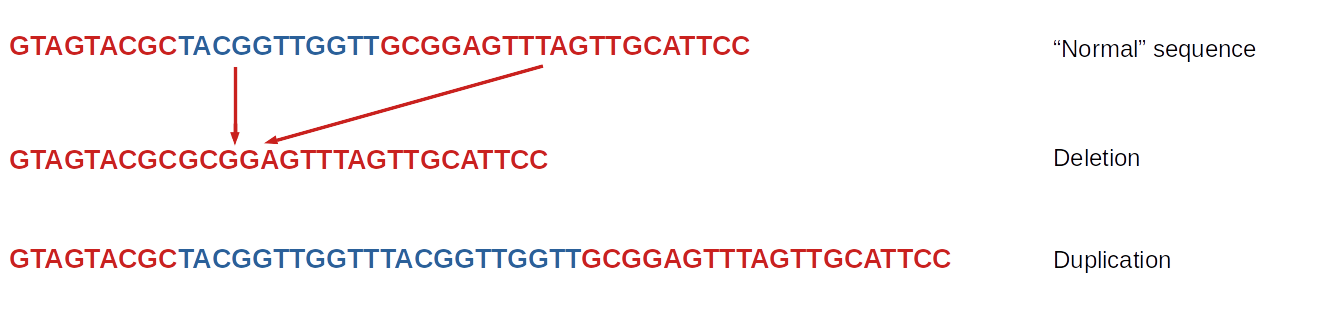

A normal genetic region that is not repeated through the genome should typically be found in two copies in each cell of a mosquito. This is because mosquitoes are diploid, and therefore carry two copies of each chromosome (except for sex chromosomes in males). Therefore, the "normal" copy number for a given genetic region is 2. We consider that there is a CNV in a region if we find samples with copy number greater or less than two. For example, the following copy numbers might be found in samples with or without duplications in a genetic region.

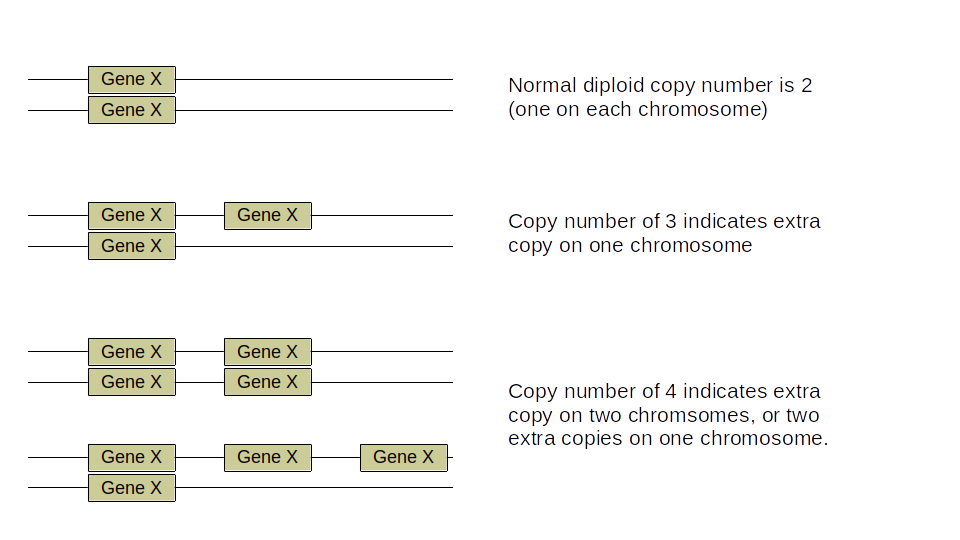

A CNV can sometimes include one or more gene-coding regions. Since multiple genes can be affected by a single CNV, it can sometimes be difficult to determine the mechanistic link between the CNV and any phenotypic effect that it is found to be associated with. In the figure below, a CNV creates two full copies of genes X and Y, and a partial copy of gene Z (which is unlikely to create a functional gene).

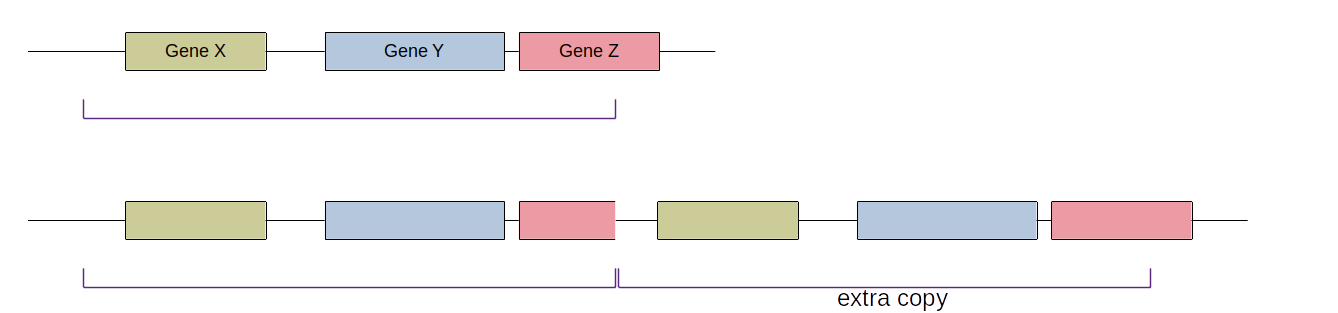

As described in the video lecture, we detect CNVs in MalariaGEN using whole genome sequencing data through a combination of coverage-based analysis (i.e., counting how much of the sequencing data comes from each region in the genome) and examination of reads from the CNV breakpoints (discordant reads).

Let's now look at how we access CNV data from MalariaGEN.

## Setup

First we need to install and import some Python packages.

In [ ]:
!pip install -q --no-warn-conflicts malariagen_data

In [ ]:
import malariagen_data
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh.io as bkio
bkio.output_notebook()

Once the packages are imported, set up data access through the `malariagen_data` package.

In [ ]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0
Results cache           : None
Cohorts analysis        : 20230516
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 7.13.0
Client location         : Washington, D.C., US
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

Inspect which sample sets are available within the MalariaGEN Ag3.0 data release.

In [ ]:
df_sample_sets = ag3.sample_sets(release="3.0")
df_sample_sets

,sample_set,sample_count,study_id,study_url,release
0,AG1000G-AO,81,AG1000G-AO,https://www.malariagen.net/network/where-we-wo...,3.0
1,AG1000G-BF-A,181,AG1000G-BF-1,https://www.malariagen.net/network/where-we-wo...,3.0
2,AG1000G-BF-B,102,AG1000G-BF-1,https://www.malariagen.net/network/where-we-wo...,3.0
3,AG1000G-BF-C,13,AG1000G-BF-2,https://www.malariagen.net/network/where-we-wo...,3.0
4,AG1000G-CD,76,AG1000G-CD,https://www.malariagen.net/network/where-we-wo...,3.0
5,AG1000G-CF,73,AG1000G-CF,https://www.malariagen.net/network/where-we-wo...,3.0
6,AG1000G-CI,80,AG1000G-CI,https://www.malariagen.net/network/where-we-wo...,3.0
7,AG1000G-CM-A,303,AG1000G-CM-1,https://www.malariagen.net/network/where-we-wo...,3.0
8,AG1000G-CM-B,97,AG1000G-CM-2,https://www.malariagen.net/network/where-we-wo...,3.0
9,AG1000G-CM-C,44,AG1000G-CM-3,https://www.malariagen.net/network/where-we-wo...,3.0


In this module we will use the Côte d'Ivoire sample set ("AG1000G-CI") from the Ag3.0 release to demonstrate accessing CNV data.

## Load the CNV HMM data

The HMM data include:

- The raw coverage calls ("call_RawCov" - the number of reads aligning in each 300bp window along the chromosome).

- Normalised coverage calls ("call_NormCov" - the raw coverage divided by expected coverage and multiplied by 2, such unduplicated regions have the expected diploid copy number value of 2).

- Copy number calls, which is the output of the HMM ("call_CN" - the estimated copy number in each 300 bp window).



In [ ]:
hmm = ag3.cnv_hmm(region="2R", sample_sets="AG1000G-CI").set_index(samples="sample_id")
hmm

<xarray.Dataset>
Dimensions:                   (variants: 205151, samples: 77)
Coordinates:
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(205151,), meta=np.ndarray>
  * samples                   (samples) object 'AY0072-C' ... 'AY0058-C'
Dimensions without coordinates: variants
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 62), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 62), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 62), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(77,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(77,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
type(hmm)

xarray.core.dataset.Dataset

In [ ]:
hmm.to_dataframe()

call_CN  call_RawCov  call_NormCov  \
variants samples                                        
0        AY0072-C        3          183         3.297   
         AY0062-C        3          170         2.906   
         AY0055-C        3          189         3.375   
         AY0034-C        4          296         4.259   
         AY0078-C        3          192         3.254   
...                    ...          ...           ...   
205150   AY0017-C       -1           -1           NaN   
         AY0043-C       -1           -1           NaN   
         AY0013-C       -1           -1           NaN   
         AY0036-C       -1           -1           NaN   
         AY0058-C       -1           -1           NaN   

                   sample_coverage_variance  sample_is_high_variance  \
variants samples                                                       
0        AY0072-C                  0.068463                    False   
         AY0062-C                  0.069416                    False   
         AY0055-C                  0.064421                    False   
         AY0034-C                  0.070073                    False   
         AY0078-C                  0.071648                    False   
...                                     ...                      ...   
205150   AY0017-C                  0.080805                    False   
         AY0043-C                  0.076374                    False   
         AY0013-C                  0.069021                    False   
         AY0036-C                  0.070174                    False   
         AY0058-C                  0.079569                    False   

                   variant_position  variant_end  variant_contig  
variants samples                                                  
0        AY0072-C                 1          300               0  
         AY0062-C                 1          300               0  
         AY0055-C                 1          300               0  
         AY0034-C                 1          300               0  
         AY0078-C                 1          300               0  
...                             ...          ...             ...  
205150   AY0017-C          61545001     61545105               0  
         AY0043-C          61545001     61545105               0  
         AY0013-C          61545001     61545105               0  
         AY0036-C          61545001     61545105               0  
         AY0058-C          61545001     61545105               0  

[15796627 rows x 8 columns]

By inspecting the dataset, we can see that the data comprise 77 samples and 205,151 variants. Here each "variant" is one 300bp window, so the first value will represent the first 300 bp window, the second value will be the second window, and so on.

As an example in this workbook, we will look at the coverage data in four samples.

In [ ]:
sample_names = ['AY0046-C', 'AY0062-C', 'AY0055-C', 'AY0034-C']

We can plot coverage in the *Cyp6aa* / *Cyp6p* cluster of genes, which have been shown to be involved in insecticide resistance.

The plots below show this region of the genome, which is on chromosome 2R between positions 28,460,000--28,580,000, with genomic position on the X axis. The black markers show normalised coverage, while the blue line shows the estimated copy number (i.e., the output of the HMM) at each 300 bp window.

In [ ]:
for s in sample_names:
    ag3.plot_cnv_hmm_coverage(s, sample_set='AG1000G-CI', region='2R:28,460,000-28,580,000')

From the plots above, we can see that each of those four samples have increased copy number (blue line higher than 2) in at least part of the region which we are looking at. Samples 2 and 3 look like they each have two CNVs in the region (two areas where copy number increases and then drops again).

The malariagen package also provides a convenient function to visualise the HMM output for many samples at once, as a heatmap.

In [ ]:
ag3.plot_cnv_hmm_heatmap(
    region = '2R:28,460,000-28,580,000',
    sample_sets = 'AG1000G-CI',
    row_height = 5
);

We can now look more precisely at which CNV alleles those two samples carry by looking at the discordant read data.

## Load the CNV discordant read calls

The CNV discordant read calls provide allele-specific CNV genotypes at a selection of genomic loci known to be involved in insecticide resistance.

In [ ]:
discordant_read_calls = (
    ag3
    .cnv_discordant_read_calls(contig="2R", sample_sets="AG1000G-CI")
    .set_index(samples="sample_id", variants="variant_id")
)
discordant_read_calls

<xarray.Dataset>
Dimensions:                        (variants: 40, samples: 80)
Coordinates:
    variant_position               (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    variant_end                    (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    variant_contig                 (variants) uint8 dask.array<chunksize=(40,), meta=np.ndarray>
  * samples                        (samples) object 'AY0072-C' ... 'AY0058-C'
  * variants                       (variants) object 'Ace1_Dup0' ... 'Cyp6aap...
Data variables:
    variant_Region                 (variants) object dask.array<chunksize=(40,), meta=np.ndarray>
    variant_StartBreakpointMethod  (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    variant_EndBreakpointMethod    (variants) int32 dask.array<chunksize=(40,), meta=np.ndarray>
    call_genotype                  (variants, samples) int8 dask.array<chunksize=(40, 64), meta=np.ndarray>
    sample_coverage_variance       (samples) float32 dask.array<chunksize=(80,), meta=np.ndarray>
    sample_is_high_variance        (samples) bool dask.array<chunksize=(80,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

Let's pull out the discordant read calls in the *Cyp6aa* / *Cyp6p* region for the four samples we focused on above.

In [ ]:
# Locate the CNV alleles from the Cyp6aa / Cyp6p region
loc_cyp6aap = discordant_read_calls["variant_Region"].values == 'Cyp6aa/Cyp6p'

# Select data for our genes and samples of interest
discordant_read_calls_cyp6aap = (
    discordant_read_calls
    .isel(variants=loc_cyp6aap)
    .sel(samples=sample_names)
)

# Convert genotypes to a pandas DataFrame
df_cyp6aap = discordant_read_calls_cyp6aap["call_genotype"].to_pandas()

# Remove CNVs that are absent in all samples
df_cyp6aap = df_cyp6aap.loc[(df_cyp6aap != 0).any(axis=1)]
df_cyp6aap

samples,AY0046-C,AY0062-C,AY0055-C,AY0034-C
variants,,,,
Cyp6aap_Dup0,0,1,1,1
Cyp6aap_Dup7,0,1,1,0
Cyp6aap_Dup11,0,0,1,0
Cyp6aap_Dup15,0,1,0,1


Each of the CNV alleles in this region are labelled "Cyp6aap_Dupxx", where xx is an identifier associated with each allele. "Dup0" is a special name which is not associated with a given allele, but instead indicates whether any gene in the region carried a CNV based on modal copy number (i.e., whether the HMM output indicated a CNV in this gene).

From the table above, we can see that sample AY0046-C has no CNV, AY0034-C has one CNV, and samples 2 and 3 have two CNVs each. AY0062-C has Dup7 and Dup15, while AY0055-C has Dup7 and Dup11.

Let's check where each of these CNVs start and end, and see whether this corresponds to the coverage increases we saw in the HMM data.

In [ ]:
dup_positions = (
    discordant_read_calls
    .reset_coords()
    [["variant_position", "variant_end"]]
    .sel(variants=["Cyp6aap_Dup7", "Cyp6aap_Dup11", "Cyp6aap_Dup15"])
    .to_dataframe()
)
dup_positions

,variant_position,variant_end
variants,,
Cyp6aap_Dup7,28478057,28486036
Cyp6aap_Dup11,28487546,28518123
Cyp6aap_Dup15,28465673,28555300


## Load the per-gene modal copy number data

We can also look at individual genes and ask whether copy number was increased in each of those genes. This table shows the copy number observed for each gene in the *Cyp6aa* and *Cyp6p* cluster, with 2 being the normal diploid copy number (no CNV).

In [ ]:
# Access per-gene modal copy number data for all genes in chromosome arm 2R
gene_copy_number = (
    ag3.gene_cnv(region="2R", sample_sets="AG1000G-CI")
    .set_index(genes="gene_id", samples="sample_id")
)

# Define genes of interest
cyp6aap_genes = dict(AGAP002862='Cyp6aa1',
                     AGAP013128='Cyp6aa2',
                     AGAP002868='Cyp6p1',
                     AGAP002869='Cyp6p2',
                     AGAP002865='Cyp6p3',
                     AGAP002867='Cyp6p4',
                     AGAP002866='Cyp6p5')

# Select data for genes of interest, excluding samples with poor quality HMM data
cyp6aap_gene_copy_number = (
    gene_copy_number["CN_mode"]
    .sel(genes=list(cyp6aap_genes.keys()))
    .where(~gene_copy_number.sample_is_high_variance, drop=True)
    .transpose()
    .to_pandas()
    .rename(cyp6aap_genes, axis='columns')
)

cyp6aap_gene_copy_number

Load CNV HMM data:   0%|          | 0/24 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/3668 [00:00<?, ?it/s]

genes,Cyp6aa1,Cyp6aa2,Cyp6p1,Cyp6p2,Cyp6p3,Cyp6p4,Cyp6p5
samples,,,,,,,
AY0072-C,3.0,3.0,3.0,3.0,3.0,3.0,3.0
AY0062-C,4.0,4.0,3.0,3.0,3.0,3.0,3.0
AY0055-C,3.0,3.0,4.0,4.0,4.0,4.0,4.0
AY0034-C,3.0,3.0,3.0,3.0,3.0,3.0,3.0
AY0078-C,3.0,3.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...
AY0017-C,3.0,3.0,3.0,3.0,3.0,3.0,3.0
AY0043-C,4.0,4.0,5.0,5.0,5.0,5.0,5.0
AY0013-C,4.0,4.0,5.0,5.0,5.0,5.0,5.0


We can show this as a heatmap for easier viewing. We'll just show the top 25 samples to keep the table small.

In [ ]:
def plot_gene_cnv_heatmap(data):

    # create a figure
    figsize = data.shape[1], data.shape[0]*0.7
    fig, ax = plt.subplots(figsize=figsize)

    # plot a heatmap
    sns.heatmap(
        data,
        annot=True,
        cbar=False,
        cmap='bwr',
        center=2,
        linewidths=0.05,
        ax=ax
    )

    # tidy plot
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
        left=False
    )
    ax.xaxis.set_label_position('top')


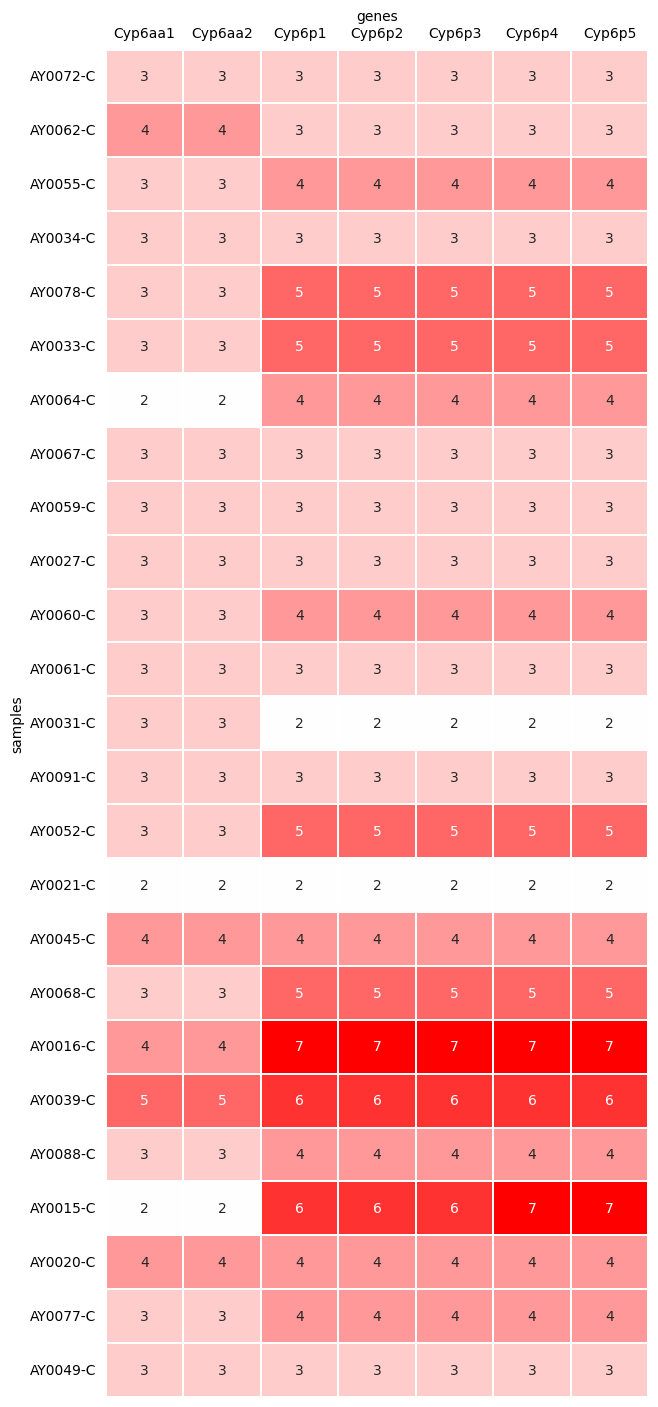

In [ ]:
plot_gene_cnv_heatmap(cyp6aap_gene_copy_number.iloc[:25])

Notice how the copy number for each gene in each sample corresponds to the HMM in that gene's region in your coverage plots above.

## Exercises

### English

1. Open this notebook in Google Colab and run it for yourself from top to bottom. Hint: click the rocket icon (<i class="fas fa-rocket"></i>) at the top of the page, then select “Colab” from the drop-down menu. When colab opens, click the "Edit" menu, then select "Clear all outputs", then begin running the cells. Make sure it runs without any errors, and take some time to try and understand what is being shown in the output.

1. Now go back to the "Load the CNV HMM data" section. Change the code so that it looks at chromosome 3R from position 28,570,000 to 28,630,000 and sample_set AG1000G-BF-A, and plots the coverage data for samples AB0086-Cx, AB0095-Cx and AB0123-C. Once you have changed the code, run those cells again. How many CNVs are found in each of those samples? How many extra copies are associated with the CNV in each sample?

1. Now go to the "Load the per-gene modal copy number data" section. Change the code again to focus on chromosome 3R and sample set AG1000G-BF-A. Create a heatmap of copy number for the genes in the *Gste* cluster. Which genes are found to have increased copy number in this sample set? Does what you see fit with the copy number plots that you made above for samples AB0086-Cx, AB0095-Cx and AB0123-C? Hint: here are the AGAP numbers for those genes:
```python
   gste_genes = dict(AGAP009195='Gste1',
                     AGAP009194='Gste2',
                     AGAP009197='Gste3',
                     AGAP009193='Gste4',
                     AGAP009192='Gste5',
                     AGAP009191='Gste6',
                     AGAP009196='Gste7')
```

1. Try again with samples AA0100-C and AA0135-C from sample set AG1000G-GH, looking again at *Gste* genes. How does that CNV compare with the one you found above? Which genes are now found to have increased copy number?


# EXERCISE SOLUTIONS

## Task 2

### Loading CNV HMM data

In [ ]:
# Load HMM data
hmm2 = ag3.cnv_hmm(region="3R", sample_sets="AG1000G-BF-A").set_index(samples="sample_id")
hmm2

<xarray.Dataset>
Dimensions:                   (variants: 177336, samples: 178)
Coordinates:
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(177336,), meta=np.ndarray>
  * samples                   (samples) object 'AB0085-Cx' ... 'AB0284-C'
Dimensions without coordinates: variants
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 62), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 62), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 62), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(178,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(178,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

### Coverage data for samples `AB0086-Cx`, `AB0095-Cx` and `AB0123-C`.

In [ ]:
sample_names2 = ['AB0086-Cx', 'AB0095-Cx', 'AB0123-C']

for s in sample_names2:
    ag3.plot_cnv_hmm_coverage(s, sample_set='AG1000G-BF-A', region='3R:28,570,000-28,630,000')

There are 0 CNVs in AB0086-Cx, 2 CNVs in AB0095-Cx, and 1 CNV in AB0123-C

### CNV HMM data for the `3R:28,570,000-28,630,000` region of the `AG1000G-BF-A` as heatmap.

In [ ]:
# Visualizing the HMM output as a heatmap
ag3.plot_cnv_hmm_heatmap(
    region='3R:28,570,000-28,630,000',
    sample_sets='AG1000G-BF-A',
    row_height=5)

- From the heatmap, there is an increase in the Copy number of the `Gste2` gene (ranging from 3-8 copies) and in the `AGAP009198` gene (ranging from 3-4 copies) for some of the samples in the `AG1000G-BF-A` sample_set

In [ ]:
# Load discordant read calls
discordant_read_calls = (
    ag3
    .cnv_discordant_read_calls(contig="3R", sample_sets="AG1000G-BF-A")
    .set_index(samples="sample_id", variants="variant_id")
)
discordant_read_calls

<xarray.Dataset>
Dimensions:                        (variants: 29, samples: 181)
Coordinates:
    variant_position               (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    variant_end                    (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    variant_contig                 (variants) uint8 dask.array<chunksize=(29,), meta=np.ndarray>
  * samples                        (samples) object 'AB0085-Cx' ... 'AB0284-C'
  * variants                       (variants) object 'Cyp6mz_Dup0' ... 'Gstue...
Data variables:
    variant_Region                 (variants) object dask.array<chunksize=(29,), meta=np.ndarray>
    variant_StartBreakpointMethod  (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    variant_EndBreakpointMethod    (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    call_genotype                  (variants, samples) int8 dask.array<chunksize=(29, 64), meta=np.ndarray>
    sample_coverage_variance       (samples) float32 dask.array<chunksize=(181,), meta=np.ndarray>
    sample_is_high_variance        (samples) bool dask.array<chunksize=(181,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

# Task 3 - Load the per-gene modal copy number data

In [ ]:
# Access per-gene modal copy number data for all genes in chromosome arm 2R
gene_copy_number = (
    ag3.gene_cnv(region="3R", sample_sets="AG1000G-BF-A")
    .set_index(genes="gene_id", samples="sample_id")
)

# Define genes of interest
gste_genes = dict(AGAP009195='Gste1',
                  AGAP009194='Gste2',
                  AGAP009197='Gste3',
                  AGAP009193='Gste4',
                  AGAP009192='Gste5',
                  AGAP009191='Gste6',
                  AGAP009196='Gste7')

# Select data for genes of interest, excluding samples with poor quality HMM data
gste_gene_copy_number = (
    gene_copy_number["CN_mode"]
    .sel(genes=list(gste_genes.keys()))
    .where(~gene_copy_number.sample_is_high_variance, drop=True)
    .transpose()
    .to_pandas()
    .rename(gste_genes, axis='columns')
)

gste_gene_copy_number

Load CNV HMM data:   0%|          | 0/24 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2686 [00:00<?, ?it/s]

genes,Gste1,Gste2,Gste3,Gste4,Gste5,Gste6,Gste7
samples,,,,,,,
AB0085-Cx,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AB0086-Cx,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AB0087-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AB0090-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AB0091-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...
AB0280-Cx,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AB0281-Cx,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AB0282-Cx,2.0,2.0,2.0,2.0,2.0,2.0,2.0


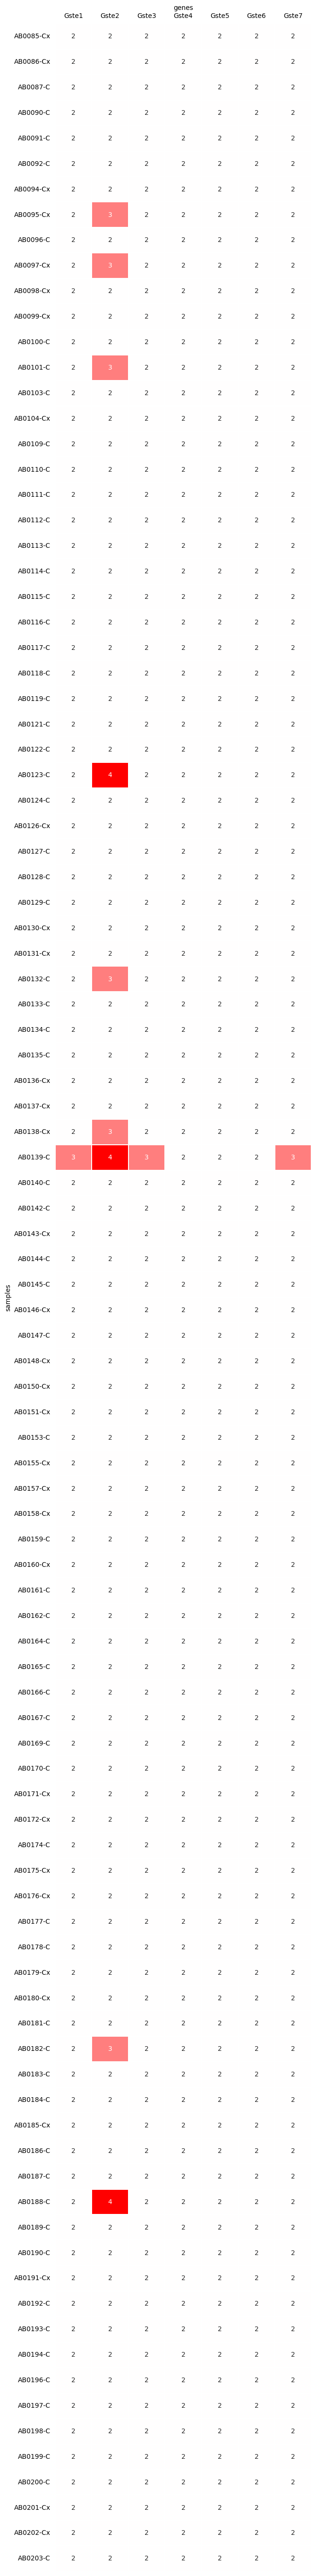

In [ ]:
plot_gene_cnv_heatmap(gste_gene_copy_number.iloc[:100])

Yes, the number of CNVs are the same as those seen in the plot.
Genes Gtse2 had increased copy numbers of 3 and 4 for samples AB0095-Cx and AB0123-C respectively.

### Task 4: Try again with samples AA0100-C and AA0135-C from sample set AG1000G-GH

In [ ]:
# Load HMM data
hmm3 = ag3.cnv_hmm(region="3R", sample_sets="AG1000G-GH").set_index(samples="sample_id")
hmm3

<xarray.Dataset>
Dimensions:                   (variants: 177336, samples: 100)
Coordinates:
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(177336,), meta=np.ndarray>
  * samples                   (samples) object 'AA0052-C' ... 'AA0108-C'
Dimensions without coordinates: variants
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 64), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 64), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 64), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
# plot the coverage data for samples AB0086-Cx, AB0095-Cx and AB0123-C.
sample_names2 = ['AA0100-C', 'AA0135-C']

for s in sample_names2:
    ag3.plot_cnv_hmm_coverage(s, sample_set='AG1000G-GH', region='3R:28,570,000-28,630,000')

There is 1 CNV in each of the samples, in the region `3R:285,590,000-28,604,000` where the Gste gene cluster is found.

In [ ]:
# Visualizing the HMM output as a heatmap
ag3.plot_cnv_hmm_heatmap(
    region='3R:28,570,000-28,630,000',
    sample_sets='AG1000G-GH',
    row_height=5)

In [ ]:
# Load discordant read calls
discordant_read_calls = (
    ag3
    .cnv_discordant_read_calls(contig="3R", sample_sets="AG1000G-GH")
    .set_index(samples="sample_id", variants="variant_id")
)
discordant_read_calls

<xarray.Dataset>
Dimensions:                        (variants: 29, samples: 100)
Coordinates:
    variant_position               (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    variant_end                    (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    variant_contig                 (variants) uint8 dask.array<chunksize=(29,), meta=np.ndarray>
  * samples                        (samples) object 'AA0052-C' ... 'AA0108-C'
  * variants                       (variants) object 'Cyp6mz_Dup0' ... 'Gstue...
Data variables:
    variant_Region                 (variants) object dask.array<chunksize=(29,), meta=np.ndarray>
    variant_StartBreakpointMethod  (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    variant_EndBreakpointMethod    (variants) int32 dask.array<chunksize=(29,), meta=np.ndarray>
    call_genotype                  (variants, samples) int8 dask.array<chunksize=(29, 64), meta=np.ndarray>
    sample_coverage_variance       (samples) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sample_is_high_variance        (samples) bool dask.array<chunksize=(100,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
# Access per-gene modal copy number data for all genes in chromosome arm 2R
gene_copy_number = (
    ag3.gene_cnv(region="3R", sample_sets="AG1000G-GH")
    .set_index(genes="gene_id", samples="sample_id")
)

# Define genes of interest
gste_genes = dict(AGAP009195='Gste1',
                  AGAP009194='Gste2',
                  AGAP009197='Gste3',
                  AGAP009193='Gste4',
                  AGAP009192='Gste5',
                  AGAP009191='Gste6',
                  AGAP009196='Gste7')

# Select data for genes of interest, excluding samples with poor quality HMM data
gste_gene_copy_number = (
    gene_copy_number["CN_mode"]
    .sel(genes=list(gste_genes.keys()))
    .where(~gene_copy_number.sample_is_high_variance, drop=True)
    .transpose()
    .to_pandas()
    .rename(gste_genes, axis='columns')
)

gste_gene_copy_number

Load CNV HMM data:   0%|          | 0/12 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/2686 [00:00<?, ?it/s]

genes,Gste1,Gste2,Gste3,Gste4,Gste5,Gste6,Gste7
samples,,,,,,,
AA0052-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AA0103-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AA0115-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AA0050-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AA0134-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...
AA0135-C,4.0,4.0,4.0,2.0,2.0,2.0,4.0
AA0124-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AA0045-C,2.0,2.0,2.0,2.0,2.0,2.0,2.0


The CNV numbers same as those in the plots.
Genes *Gtse1, Gtse2, Gtse3* and Gtse7 have increased copy number of 4 each, in sample AA0135-C.

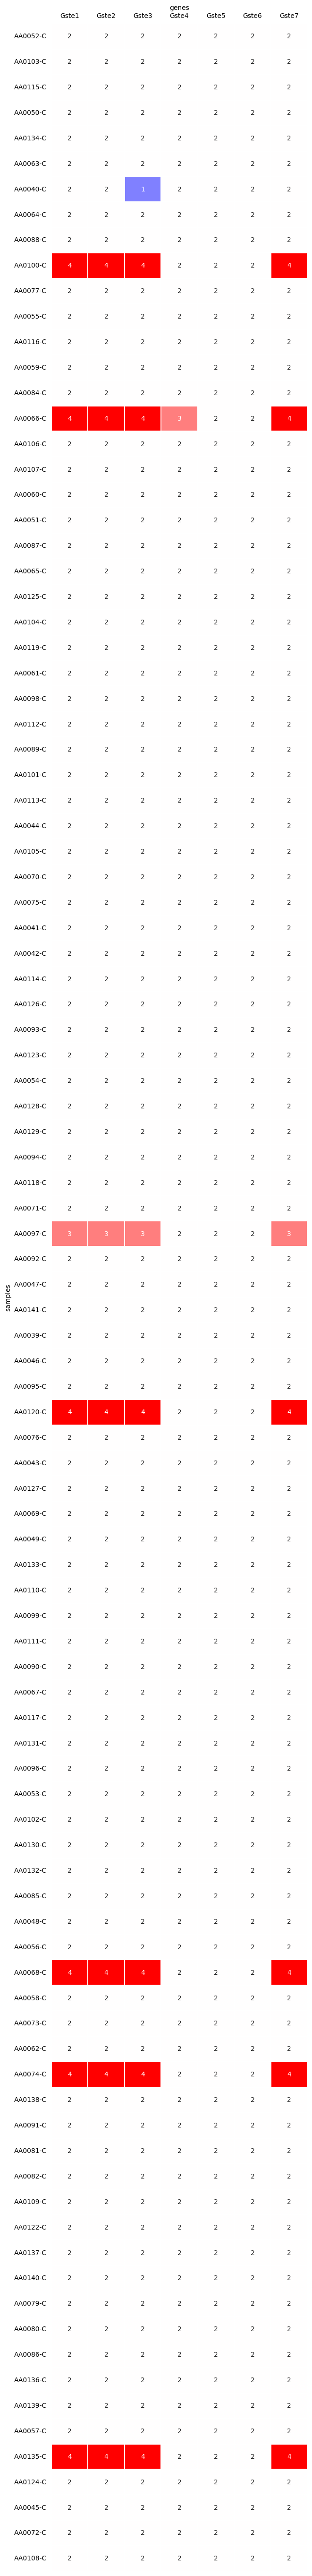

In [ ]:
plot_gene_cnv_heatmap(gste_gene_copy_number.iloc[:100])